In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from scipy import sparse

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc , roc_auc_score

import tensorflow as tf
import keras 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Bag of words

##Loading the data

In [11]:
#loading the data from which we have saved in npz format. Note PCA does NOT support sparse matrix as input data,
#hence we need to convert the input into any of the supported format(eg pandas dataframe)
X_train=sparse.load_npz("/content/drive/My Drive/Amazon fine food/Vectorized data/bow_train.npz")


#labels are stored in csv format. Note y_s have an additional column "Unnamed :0 "
#It was created while creating the data frame . 
y_train= np.array(pd.read_csv("/content/drive/My Drive/Amazon fine food/Vectorized data/y_train.csv").drop( 'Unnamed: 0',axis=1)) 
print("shape of training data " , X_train.shape)

shape of training data  (254919, 19388)


In [12]:
X_cv = sparse.load_npz("/content/drive/My Drive/Amazon fine food/Vectorized data/bow_cv.npz")

y_cv = np.array(pd.read_csv("/content/drive/My Drive/Amazon fine food/Vectorized data/y_cv.csv").drop( 'Unnamed: 0',axis=1))

print("Shape of validation data ", X_cv.shape)

Shape of validation data  (54626, 19388)


In [13]:
X_test = sparse.load_npz("/content/drive/My Drive/Amazon fine food/Vectorized data/bow_test.npz")

y_test = np.array(pd.read_csv("/content/drive/My Drive/Amazon fine food/Vectorized data/y_test.csv").drop( 'Unnamed: 0',axis=1))

print("Shape of validation data ", X_cv.shape)

Shape of validation data  (54626, 19388)


In [9]:
#shallow model
#input() >> relu(500) >> dropout(0.25) >> sigmoid(1)  
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(X_train.shape[1] , sparse= True),
  tf.keras.layers.Dense(500 , activation= 'relu') ,
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(1 , activation= 'sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 500)               9694500   
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 501       
Total params: 9,695,001
Trainable params: 9,695,001
Non-trainable params: 0
_________________________________________________________________


In [20]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits= True)

In [11]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [12]:
history = model.fit(
    x = X_train  , y = y_train,
    validation_data = (X_cv, y_cv),
    epochs = 20, batch_size = 128 ,
    callbacks =[
                keras.callbacks.EarlyStopping(monitor = 'val_accuracy' , patience = 4)
    ]
)

Epoch 1/20
1992/1992 [==============================] - 17s 9ms/step - loss: 0.4191 - accuracy: 0.9146 - val_loss: 0.4105 - val_accuracy: 0.9244
Epoch 2/20
1992/1992 [==============================] - 17s 8ms/step - loss: 0.4055 - accuracy: 0.9340 - val_loss: 0.4101 - val_accuracy: 0.9268
Epoch 3/20
1992/1992 [==============================] - 16s 8ms/step - loss: 0.4021 - accuracy: 0.9414 - val_loss: 0.4102 - val_accuracy: 0.9279
Epoch 4/20
1992/1992 [==============================] - 16s 8ms/step - loss: 0.3992 - accuracy: 0.9472 - val_loss: 0.4101 - val_accuracy: 0.9274
Epoch 5/20
1992/1992 [==============================] - 16s 8ms/step - loss: 0.3963 - accuracy: 0.9540 - val_loss: 0.4095 - val_accuracy: 0.9277
Epoch 6/20
1992/1992 [==============================] - 18s 9ms/step - loss: 0.3935 - accuracy: 0.9601 - val_loss: 0.4097 - val_accuracy: 0.9287
Epoch 7/20
1992/1992 [==============================] - 17s 8ms/step - loss: 0.3911 - accuracy: 0.9654 - val_loss: 0.4093 - val_ac

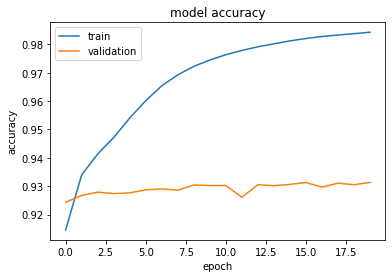

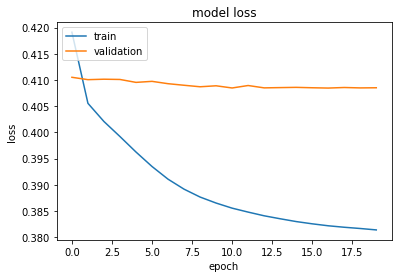

In [13]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [25]:
#saving the model
model.save("model.h5")

In [26]:
model = keras.models.load_model("/content/drive/My Drive/model.h5")

AUC score on test data 0.9459805161241897


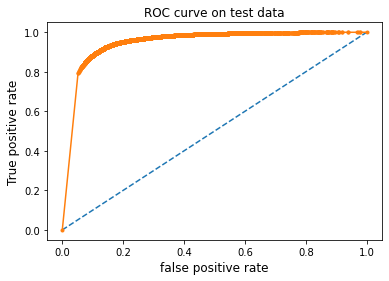

macro f1 score for data : 0.8658524096124933
micro f1 scoore for data: 0.9303079119833046
hamming loss for data: 0.06969208801669535
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.80      0.75      0.77      8646
           1       0.95      0.96      0.96     45980

    accuracy                           0.93     54626
   macro avg       0.88      0.86      0.87     54626
weighted avg       0.93      0.93      0.93     54626



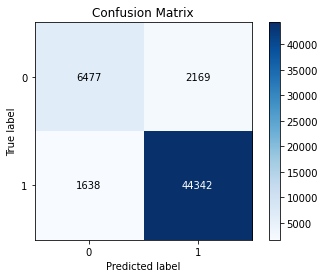

In [45]:
#testing the model
import scikitplot.metrics as skplt

prediction =  model.predict(X_test)
print("AUC score on test data", roc_auc_score(y_test,prediction))

fpr, tpr, thresholds= metrics.roc_curve(y_test, prediction )
plt.plot([0,1],[0,1],linestyle='--')# for a random(dumb) model
plt.plot(fpr,tpr,marker='.')
plt.title(r"ROC curve on test data")
plt.xlabel("false positive rate", fontsize=12)
plt.ylabel("True positive rate", fontsize=12)
plt.show()


skplt.plot_confusion_matrix(y_test, np.round(prediction))
print("macro f1 score for data :",metrics.f1_score(y_test,  np.round(prediction), average = 'macro'))
print("micro f1 scoore for data:",metrics.f1_score(y_test,  np.round(prediction), average = 'micro'))
print("hamming loss for data:",metrics.hamming_loss(y_test, np.round(prediction)))
print("Precision recall report for data:\n",metrics.classification_report(y_test,  np.round(prediction)))

#Word 2 vec

In [14]:
X_train=sparse.load_npz("/content/drive/My Drive/Amazon fine food/Vectorized data/w2v_train.npz")
X_train = X_train.A
print("Shape of trining data ", X_train.shape)

Shape of trining data  (254919, 50)


In [15]:
X_cv = sparse.load_npz("/content/drive/My Drive/Amazon fine food/Vectorized data/w2v_cv.npz")


X_cv = X_cv.A
print("Shape of validation data ", X_cv.shape)

Shape of validation data  (54626, 50)


In [16]:
X_test = sparse.load_npz("/content/drive/My Drive/Amazon fine food/Vectorized data/w2v_test.npz")

X_test = X_test.A

print("Shape of validation data ", X_test.shape)

Shape of validation data  (54626, 50)


In [23]:
#shallow model  
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer( 50 ),

  tf.keras.layers.Dense(200 , activation= 'relu') ,
  tf.keras.layers.Dropout(0.3),

  tf.keras.layers.Dense(400 , activation= 'relu') ,
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.BatchNormalization(),

  tf.keras.layers.Dense(200 , activation= 'relu') ,
  tf.keras.layers.Dropout(0.3),

  tf.keras.layers.Dense( 50 , activation= 'relu') ,
  tf.keras.layers.Dropout(0.3),

  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(1 , activation= 'sigmoid')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 200)               10200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 400)               80400     
_________________________________________________________________
dropout_8 (Dropout)          (None, 400)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 400)               1600      
_________________________________________________________________
dense_11 (Dense)             (None, 200)               80200     
_________________________________________________________________
dropout_9 (Dropout)          (None, 200)              

In [24]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [25]:
history = model.fit(
    x = X_train, y = y_train , 
    validation_data = (X_cv, y_cv),
    epochs = 20, batch_size = 128 
)

Epoch 1/20
1992/1992 [==============================] - 12s 6ms/step - loss: 0.4303 - accuracy: 0.8825 - val_loss: 0.4243 - val_accuracy: 0.8968
Epoch 2/20
1992/1992 [==============================] - 12s 6ms/step - loss: 0.4247 - accuracy: 0.8947 - val_loss: 0.4250 - val_accuracy: 0.9027
Epoch 3/20
1992/1992 [==============================] - 12s 6ms/step - loss: 0.4236 - accuracy: 0.8971 - val_loss: 0.4227 - val_accuracy: 0.9021
Epoch 4/20
1992/1992 [==============================] - 12s 6ms/step - loss: 0.4226 - accuracy: 0.8995 - val_loss: 0.4229 - val_accuracy: 0.9052
Epoch 5/20
1992/1992 [==============================] - 12s 6ms/step - loss: 0.4219 - accuracy: 0.9012 - val_loss: 0.4233 - val_accuracy: 0.9015
Epoch 6/20
1992/1992 [==============================] - 12s 6ms/step - loss: 0.4214 - accuracy: 0.9021 - val_loss: 0.4212 - val_accuracy: 0.9061
Epoch 7/20
1992/1992 [==============================] - 12s 6ms/step - loss: 0.4211 - accuracy: 0.9024 - val_loss: 0.4207 - val_ac

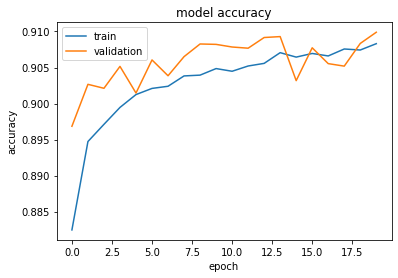

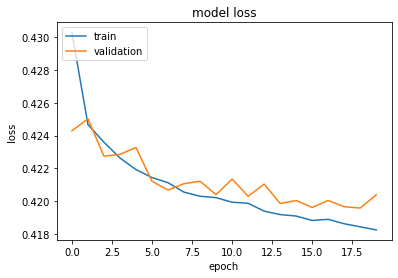

In [26]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

AUC score on test data 0.8957281409602199


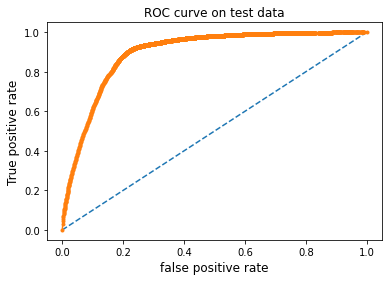

macro f1 score for data : 0.8174206287896313
micro f1 scoore for data: 0.9076996302127193
hamming loss for data: 0.09230036978728078
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.74      0.65      0.69      8646
           1       0.93      0.96      0.95     45980

    accuracy                           0.91     54626
   macro avg       0.84      0.80      0.82     54626
weighted avg       0.90      0.91      0.91     54626



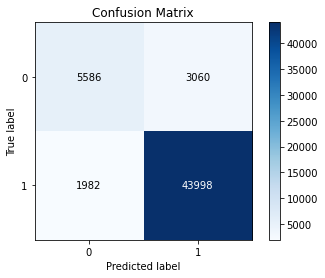

In [29]:
#testing the model
import scikitplot.metrics as skplt

prediction =  model.predict(X_test)
print("AUC score on test data", roc_auc_score(y_test,prediction))

fpr, tpr, thresholds= metrics.roc_curve(y_test, prediction )
plt.plot([0,1],[0,1],linestyle='--')# for a random(dumb) model
plt.plot(fpr,tpr,marker='.')
plt.title(r"ROC curve on test data")
plt.xlabel("false positive rate", fontsize=12)
plt.ylabel("True positive rate", fontsize=12)
plt.show()


skplt.plot_confusion_matrix(y_test, np.round(prediction))
print("macro f1 score for data :",metrics.f1_score(y_test,  np.round(prediction), average = 'macro'))
print("micro f1 scoore for data:",metrics.f1_score(y_test,  np.round(prediction), average = 'micro'))
print("hamming loss for data:",metrics.hamming_loss(y_test, np.round(prediction)))
print("Precision recall report for data:\n",metrics.classification_report(y_test,  np.round(prediction)))

In [28]:
pip install scikit-plot

1.0